In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Laad schone data
df = pd.read_csv('../data/processed/transactions_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("="*60)
print("CLEANED DATA LOADED")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst rows:")
print(df.head())

CLEANED DATA LOADED
Shape: (1631, 9)
Date range: 2024-12-08 00:00:00 to 2025-12-08 00:00:00

Columns: ['Date', 'Amount', 'Balance', 'Counterparty', 'Counterparty_IBAN', 'Description_1', 'Description_2', 'Description_3', 'Code']

First rows:
        Date  Amount  Balance                       Counterparty  \
0 2024-12-08  100.00   105.36                      J.W. Croymans   
1 2024-12-08  -25.00   180.36             CCV*Cuijkse Brouwbriga   
2 2024-12-08 -100.00    80.36                      J.W. Croymans   
3 2024-12-08  -60.00    20.36  R. Pittens via Rabo Betaalverzoek   
4 2024-12-09   -1.74    18.62                  Albert Heijn 1382   

    Counterparty_IBAN                                      Description_1  \
0  NL92RABO3031660358                                                      
1                 NaN                           CUYK, 5432DR, NLD, 12:11   
2  NL92RABO3031660358                                                      
3  NL73RABO0325301433  NL32RABO0111648904 0022

In [2]:
print("="*60)
print("CREATING DATE FEATURES")
print("="*60)

# Extract date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Day_Name'] = df['Date'].dt.day_name()
df['Week_of_Year'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Weekend indicator
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Day of month categories
df['Day_Period'] = pd.cut(df['Day'], 
                           bins=[0, 10, 20, 31], 
                           labels=['Begin', 'Middle', 'End'])

print("✅ Date features created!")
print(f"\nNew columns added: {['Year', 'Month', 'Month_Name', 'Day', 'Day_of_Week', 'Day_Name', 'Week_of_Year', 'Quarter', 'Is_Weekend', 'Day_Period']}")

print("\nSample of new features:")
print(df[['Date', 'Day_Name', 'Is_Weekend', 'Month_Name', 'Quarter', 'Day_Period']].head(10))

CREATING DATE FEATURES
✅ Date features created!

New columns added: ['Year', 'Month', 'Month_Name', 'Day', 'Day_of_Week', 'Day_Name', 'Week_of_Year', 'Quarter', 'Is_Weekend', 'Day_Period']

Sample of new features:
        Date   Day_Name  Is_Weekend Month_Name  Quarter Day_Period
0 2024-12-08     Sunday           1   December        4      Begin
1 2024-12-08     Sunday           1   December        4      Begin
2 2024-12-08     Sunday           1   December        4      Begin
3 2024-12-08     Sunday           1   December        4      Begin
4 2024-12-09     Monday           0   December        4      Begin
5 2024-12-10    Tuesday           0   December        4      Begin
6 2024-12-11  Wednesday           0   December        4     Middle
7 2024-12-11  Wednesday           0   December        4     Middle
8 2024-12-11  Wednesday           0   December        4     Middle
9 2024-12-11  Wednesday           0   December        4     Middle


In [3]:
print("="*60)
print("CREATING AMOUNT FEATURES")
print("="*60)

# Income vs Expense
df['Is_Income'] = (df['Amount'] > 0).astype(int)
df['Is_Expense'] = (df['Amount'] < 0).astype(int)

# Absolute amount
df['Amount_Abs'] = df['Amount'].abs()

# Amount categories
df['Amount_Category'] = pd.cut(df['Amount_Abs'], 
                                bins=[0, 10, 50, 100, 500, float('inf')],
                                labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])

# Log amount (for ML models, avoids large outliers)
df['Amount_Log'] = np.log1p(df['Amount_Abs'])  # log1p = log(1+x) to handle zeros

print("✅ Amount features created!")

print("\nIncome vs Expense distribution:")
print(df['Is_Income'].value_counts())

print("\nAmount categories:")
print(df['Amount_Category'].value_counts().sort_index())

print("\nSample:")
print(df[['Amount', 'Amount_Abs', 'Is_Income', 'Is_Expense', 'Amount_Category']].head(10))

CREATING AMOUNT FEATURES
✅ Amount features created!

Income vs Expense distribution:
Is_Income
0    1293
1     338
Name: count, dtype: int64

Amount categories:
Amount_Category
Very Small    689
Small         633
Medium        141
Large         150
Very Large     18
Name: count, dtype: int64

Sample:
   Amount  Amount_Abs  Is_Income  Is_Expense Amount_Category
0  100.00      100.00          1           0          Medium
1  -25.00       25.00          0           1           Small
2 -100.00      100.00          0           1          Medium
3  -60.00       60.00          0           1          Medium
4   -1.74        1.74          0           1      Very Small
5   -3.76        3.76          0           1      Very Small
6  390.09      390.09          1           0           Large
7  -29.55       29.55          0           1           Small
8  -39.70       39.70          0           1           Small
9  -66.68       66.68          0           1          Medium


In [4]:
print("="*60)
print("CREATING TEXT FEATURES FROM DESCRIPTIONS AND COUNTERPARTY")
print("="*60)

# Combineer alle beschrijvingen
df['Description_Full'] = (
    df['Description_1'].fillna('') + ' ' + 
    df['Description_2'].fillna('') + ' ' + 
    df['Description_3'].fillna('')
).str.strip()

# Description length
df['Description_Length'] = df['Description_Full'].str.len()

# Convert to lowercase for keyword matching
df['Description_Lower'] = df['Description_Full'].str.lower()

# BELANGRIJK: Ook Counterparty meenemen!
df['Counterparty_Lower'] = df['Counterparty'].fillna('').str.lower()

# Combineer Description + Counterparty voor keyword matching
df['Combined_Text'] = df['Description_Lower'] + ' ' + df['Counterparty_Lower']

print("✅ Combined text created (Description + Counterparty)")

# VERBETERDE keywords met partial matching
keywords = {
    'supermarket': ['Toko Toko','market','Voordeelshop','Supermarke','NIGHTSHOP','NETTORAMA', 'Hambali','albert heijn', 'ah ', 'jumbo', 'lidl', 'aldi', 'plus ', 'dirk', 'coop', 'spar', 'hoogvliet', 'vomar', 'deen', 'supermarkt', 'supermarkten','Slagerij'],
    'restaurant': ['Quynh-Ly','SSP HELLAS EAT GREEK','EVERFOOD','Eethuis','Steakhou','DE RADEN EN ZOO','Vissers Gilze Raak','3010637','Luzt','bakhuus', 'e-food','Grillroom', 'Lazzarella','Vishandel','FARAO', 'Nijl','restaurant', 'cafe', 'pizza', 'burger', 'subway', 'mcdonalds', 'kfc', 'dominos', 'new york pizza', 'thuisbezorgd', 'deliveroo', 'uber eats', 'MCD', 'MC'],
    'transport': ['NLOVLD5DQBN6W4MJZ7','NSAutomaat','GoCarwash','Q PARK','NLOVP457LW86ZDDJE6','Autobedrijf', 'Tankstellen','Bijvelds','Parkeergar', 'Centraal Bureau Rijvaardigheidsbewijzen','STPARKEERGELDEN','ns.nl', 'ns ', 'ov-chipkaart', 'ov ', 'chipkaart', 'parkeren', 'parking', 'benzine', 'shell', 'esso', 'bp ', 'total', 'q8', 'tango', 'fieten olie'],
    'online': ['Emesa','klarna','google','Digitaal Bestellen','bol.com', 'bol ', 'amazon', 'paypal', 'ideal', 'adyen', 'mollie'],
    'subscription': ['spotify', 'netflix', 'ziggo', 'kpn', 't-mobile', 'vodafone', 'youtube', 'disney', 'amazon eu', 'odido'],
    'health': ['Podotherapie','Infomedics', 'apotheek', 'pharmacy', 'dokter', 'tandarts', 'ziekenhuis', 'huisarts', 'kruidvat', 'etos', 'VGZ', 'CZ'],
    'bar_cafe': ['Villa Fiesta','Bovanas B.V.','Kafee','Hertog Jan','EDELROOK','SALTY TASTE MONOPROSOP','CRYSTAL CITY HOTEL','MISTER PANTA PC', 'JR DAILY','THE PENT','GENDAL GROUP IKE', 'Sporten en Bew','Cantina','Bootje Speciaal B.V','RKSV RHODE','S.V. Blauw Geel','R.K.V.V. Keldonk','Ugly Duck','RETRO','Smullen','Dino','Partycentrum','Par-T','Johan Cruijff ArenA','STACJA','TEATRO','jmp','KOLEJE','club','MarktbelangenEindhoven','Sportsbar','The Walkabout','paaspop','studio','carnaval','Cultuur Haven Vegh','STEEKDEVEERFEEST','gjd','psv','JassieBV', 'GEA', 'Karaoke','RSCA', 'Stibmivb','bar', 'cafe', 'kroeg', 'pub', 'horeca', 'starbucks', 'Shots', 'Studio Dependance', 'SHB', 'Peppers', 'kantine'],
    'clothing': ['J & J','The Sting','h&m', 'zara', 'c&a', 'hema', 'primark', 'wehkamp', 'uniqlo'],
    'electronics': ['mediamarkt', 'coolblue', 'bol.com', 'apple'],
    'fitness': ['sportschool', 'gym', 'basic fit', 'fitness'],
    'other_shops': ['Gem. s-Hertogenbos','Cuijkse Brouwbriga','solow','NSC','CIGO','Marianka','So-Low','Bierwinkel HOP','OK ANYTIME','ANAPSYKTIRIA','AB_SHOPnGO_ATHENS_1091','GEFSEIS','MOROL MD-ALAM MD-AFT','11teamsports Greece','DOUKAS NIKOLAOS','Autogrill DUS Airport','Poort 1','F.C. Groningen','Gemeente Groningen','De Efteling', 'GUNA GUNA BV','Hellobier', 'PURPLE RAIN', 'kccg','5017 AT9 Den Bosch', 'soest','Upstairs','4208-15101', 'kiosk','4208-23101','VendingWork','Breda University as','action', 'blokker', 'xenos', 'wibra', 'ikea', 'gamma', 'praxis', 'SlijterijSpraakwat'],
    'rent': ['Dhr. Van de Wal', 'huur'],
    'salary': ['salaris', 'salary', 'loon', 'werkgever', 'employer', 'LOLO', 'M&L'],
    'atm': ['geldautomaat', 'atm', 'opname', 'withdrawal', 'geldmaat'],
    'transfer': ['overschrijving', 'transfer', 'tikkie', 'betaalverzoek', 'Revolut'],
    'insurance': ['verzekering', 'insurance', 'aegon', 'achmea', 'nn', 'nationale nederlanden'],
    'Gambling': ['Toto', 'Unibet', 'Holland Casino', 'Bet365', 'trustly Group', '711'],
    'saving': ['Vrij Spaargeld','J.W. Croymans', 'Jasper Croijmans','Szigget?'],
    'tickets': ['TO Events','SumUp *TO Events','Top Events B.V.','Event Facility Group','CM.com', 'TicketingPayments'],
    'booking': ['Booking', 'hostel'],
    'Uncle DUO': ['DUO'],
    'taxes': ['belastingdienst'],
    'Goodwill': ['Stichting'],
    'personal care': ['kapper', 'Krullen en Spullen'],
    'free time': ['Take ten']
}

# Create keyword features - NU MET COMBINED TEXT!
for category, words in keywords.items():
    pattern = '|'.join(words)
    df[f'Has_{category}'] = df['Combined_Text'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

print("✅ Text features created!")

# Toon welke keywords gevonden zijn
print("\n" + "="*60)
print("KEYWORD MATCHES FOUND")
print("="*60)
keyword_cols = [col for col in df.columns if col.startswith('Has_')]
for col in keyword_cols:
    count = df[col].sum()
    print(f"  {col.replace('Has_', '').ljust(20)}: {count:4d} transactions")

# Toon totaal aantal transacties met minstens 1 keyword match
total_with_keywords = df[keyword_cols].sum(axis=1) > 0
print(f"\n{'='*60}")
print(f"Total transactions with keywords: {total_with_keywords.sum()} / {len(df)} ({total_with_keywords.mean()*100:.1f}%)")
print(f"Transactions WITHOUT keywords: {(~total_with_keywords).sum()} ({(~total_with_keywords).mean()*100:.1f}%)")

# Toon sample descriptions met keywords
print("\n" + "="*60)
print("SAMPLE MATCHES (Counterparty + Description)")
print("="*60)
sample_with_keywords = df[df[keyword_cols].sum(axis=1) > 0][['Counterparty', 'Description_Full'] + keyword_cols].head(15)
if len(sample_with_keywords) > 0:
    for idx, row in sample_with_keywords.iterrows():
        matched_categories = [col.replace('Has_', '') for col in keyword_cols if row[col] == 1]
        print(f"\nCounterparty: {row['Counterparty'][:50]}")
        print(f"Description:  {row['Description_Full'][:50]}")
        print(f"  → Categories: {', '.join(matched_categories)}")
else:
    print("No keyword matches found")

# Toon transacties ZONDER keywords
print("\n" + "="*60)
print("TRANSACTIONS WITHOUT KEYWORDS (Top 20)")
print("="*60)
no_keywords_df = df[df[keyword_cols].sum(axis=1) == 0][['Counterparty', 'Description_Full', 'Amount']].head(20)
for idx, row in no_keywords_df.iterrows():
    counterparty = row['Counterparty'][:40] if pd.notna(row['Counterparty']) and row['Counterparty'] != 'Unknown' else ''
    description = row['Description_Full'][:40] if len(row['Description_Full']) > 0 else ''
    if counterparty or description:
        print(f"\n€{row['Amount']:7.2f} | CP: {counterparty.ljust(40)} | Desc: {description}")

CREATING TEXT FEATURES FROM DESCRIPTIONS AND COUNTERPARTY
✅ Combined text created (Description + Counterparty)
✅ Text features created!

KEYWORD MATCHES FOUND
  supermarket         :  266 transactions
  restaurant          :  164 transactions
  transport           :  172 transactions
  online              :  301 transactions
  subscription        :   39 transactions
  health              :   34 transactions
  bar_cafe            :  353 transactions
  clothing            :    3 transactions
  electronics         :    6 transactions
  fitness             :   13 transactions
  other_shops         :   99 transactions
  rent                :   12 transactions
  salary              :   44 transactions
  atm                 :    8 transactions
  transfer            :  224 transactions
  insurance           :   24 transactions
  Gambling            :  200 transactions
  saving              :  140 transactions
  tickets             :   14 transactions
  booking             :    2 transactions
 

In [5]:
print("="*60)
print("CREATING COUNTERPARTY FEATURES")
print("="*60)

# Fill missing counterparty names
df['Counterparty'] = df['Counterparty'].fillna('Unknown')

# Counterparty frequency
counterparty_freq = df['Counterparty'].value_counts()
df['Counterparty_Frequency'] = df['Counterparty'].map(counterparty_freq)

# Is recurring (appears more than once)
df['Is_Recurring'] = (df['Counterparty_Frequency'] > 1).astype(int)

print("✅ Counterparty features created!")

print(f"\nUnique counterparties: {df['Counterparty'].nunique()}")
print(f"Recurring transactions: {df['Is_Recurring'].sum()} ({df['Is_Recurring'].mean()*100:.1f}%)")

print("\nTop 10 most frequent counterparties:")
print(counterparty_freq.head(10))

CREATING COUNTERPARTY FEATURES
✅ Counterparty features created!

Unique counterparties: 392
Recurring transactions: 1406 (86.2%)

Top 10 most frequent counterparties:
Counterparty
AAB INZ TIKKIE           118
J.W. Croymans            102
Albert Heijn 1382         94
NLO - TOTO iGaming        78
Kantine                   70
Caelum Supermarkt Erp     49
ALBERT HEIJN 1382         48
Fieten Olie Erp           35
Trustly Group AB          29
M&L Italian B.V.          27
Name: count, dtype: int64


In [6]:
print("="*60)
print("CREATING TIME-BASED FEATURES")
print("="*60)

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Days since last transaction
df['Days_Since_Last'] = df['Date'].diff().dt.days
df['Days_Since_Last'] = df['Days_Since_Last'].fillna(0)

# Running balance check (already have Balance column, but calculate change)
df['Balance_Change'] = df['Balance'].diff()
df['Balance_Change'] = df['Balance_Change'].fillna(0)

# Transaction count per day
df['Transactions_Per_Day'] = df.groupby(df['Date'].dt.date)['Date'].transform('count')

# Days since start of data
df['Days_From_Start'] = (df['Date'] - df['Date'].min()).dt.days

print("✅ Time-based features created!")

print("\nTime features sample:")
print(df[['Date', 'Days_Since_Last', 'Balance_Change', 'Transactions_Per_Day', 'Days_From_Start']].head(10))

print("\nTransactions per day statistics:")
print(df['Transactions_Per_Day'].describe())

CREATING TIME-BASED FEATURES
✅ Time-based features created!

Time features sample:
        Date  Days_Since_Last  Balance_Change  Transactions_Per_Day  \
0 2024-12-08              0.0            0.00                     4   
1 2024-12-08              0.0           75.00                     4   
2 2024-12-08              0.0         -100.00                     4   
3 2024-12-08              0.0          -60.00                     4   
4 2024-12-09              1.0           -1.74                     1   
5 2024-12-10              1.0           -3.76                     1   
6 2024-12-11              1.0          390.09                     6   
7 2024-12-11              0.0          -29.55                     6   
8 2024-12-11              0.0          -39.70                     6   
9 2024-12-11              0.0          -66.68                     6   

   Days_From_Start  
0                0  
1                0  
2                0  
3                0  
4                1  
5        

FEATURE ENGINEERING SUMMARY
Original columns: 9
New columns added: 51
Total columns: 60

📋 All features:
   1. Date
   2. Amount
   3. Balance
   4. Counterparty
   5. Counterparty_IBAN
   6. Description_1
   7. Description_2
   8. Description_3
   9. Code
  10. Year
  11. Month
  12. Month_Name
  13. Day
  14. Day_of_Week
  15. Day_Name
  16. Week_of_Year
  17. Quarter
  18. Is_Weekend
  19. Day_Period
  20. Is_Income
  21. Is_Expense
  22. Amount_Abs
  23. Amount_Category
  24. Amount_Log
  25. Description_Full
  26. Description_Length
  27. Description_Lower
  28. Counterparty_Lower
  29. Combined_Text
  30. Has_supermarket
  31. Has_restaurant
  32. Has_transport
  33. Has_online
  34. Has_subscription
  35. Has_health
  36. Has_bar_cafe
  37. Has_clothing
  38. Has_electronics
  39. Has_fitness
  40. Has_other_shops
  41. Has_rent
  42. Has_salary
  43. Has_atm
  44. Has_transfer
  45. Has_insurance
  46. Has_Gambling
  47. Has_saving
  48. Has_tickets
  49. Has_booking
  50. Has_

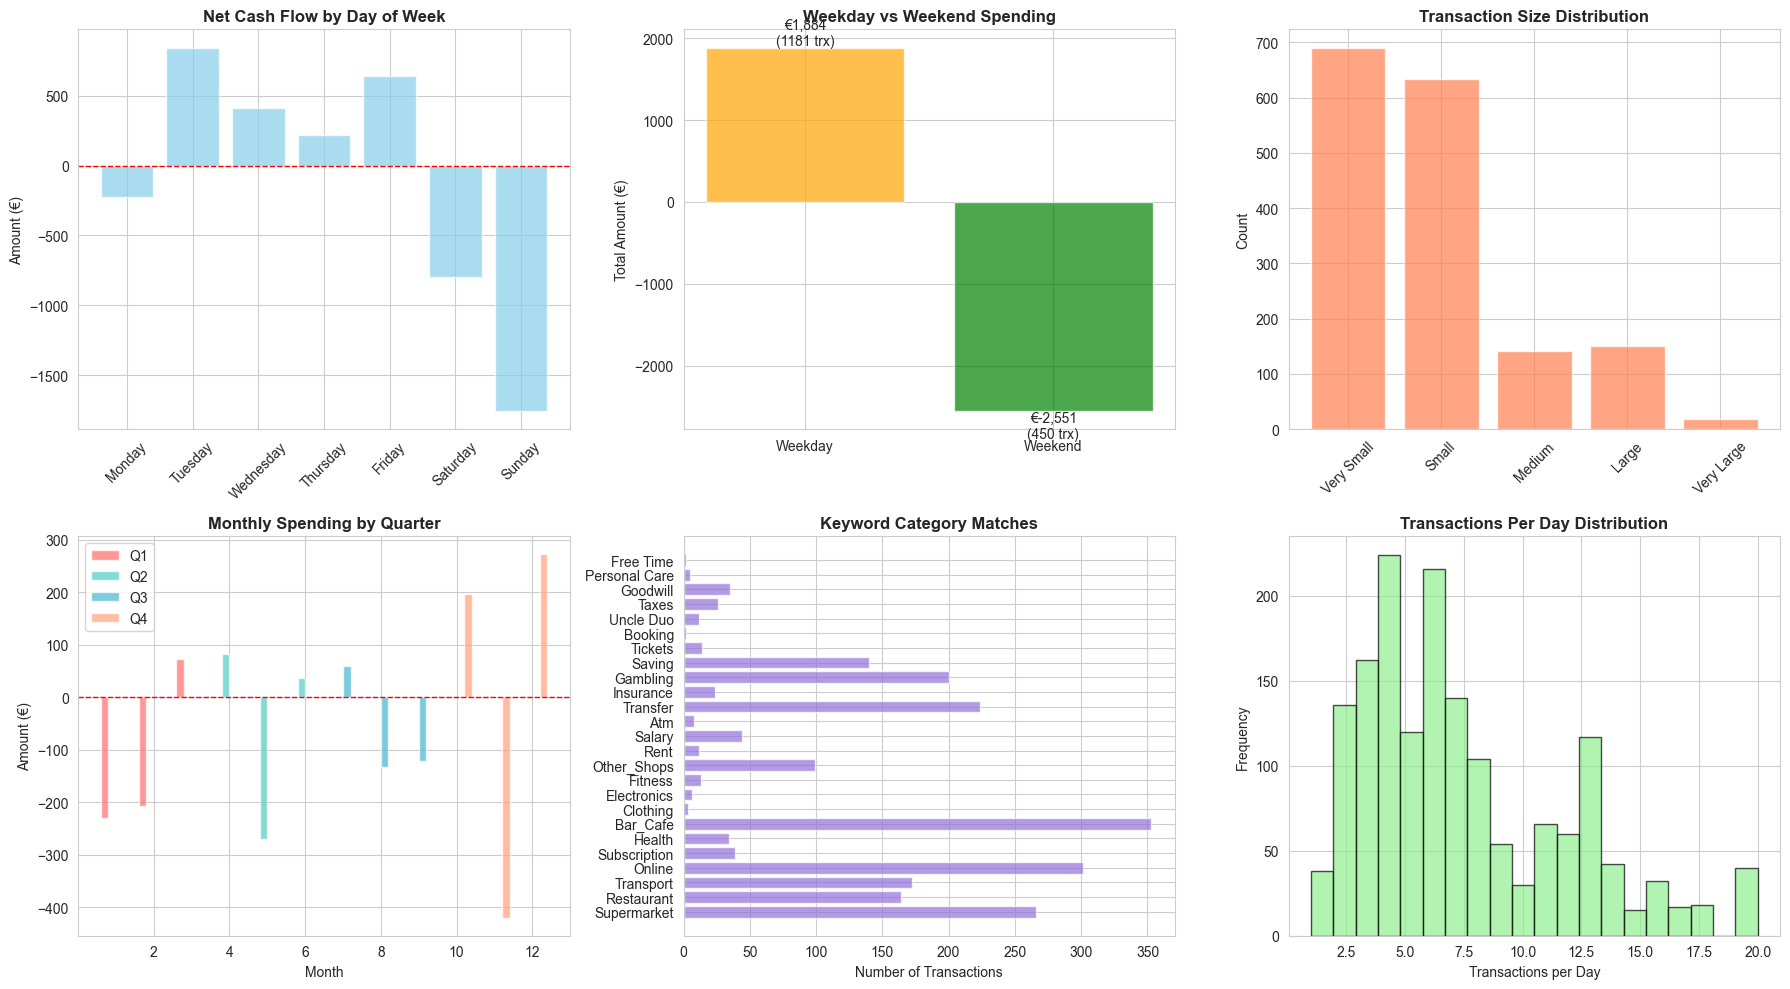

In [7]:
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

print(f"Original columns: 9")
print(f"New columns added: {len(df.columns) - 9}")
print(f"Total columns: {len(df.columns)}")

print("\n📋 All features:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*60)
print("FEATURE VISUALIZATIONS")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Spending by day of week
day_spending = df.groupby('Day_Name')['Amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
axes[0, 0].bar(range(7), day_spending.values, color='skyblue', alpha=0.7)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(day_spending.index, rotation=45)
axes[0, 0].set_title('Net Cash Flow by Day of Week', fontweight='bold')
axes[0, 0].set_ylabel('Amount (€)')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)

# 2. Weekend vs Weekday
weekend_data = df.groupby('Is_Weekend')['Amount'].agg(['sum', 'count'])
axes[0, 1].bar(['Weekday', 'Weekend'], weekend_data['sum'].values, color=['orange', 'green'], alpha=0.7)
axes[0, 1].set_title('Weekday vs Weekend Spending', fontweight='bold')
axes[0, 1].set_ylabel('Total Amount (€)')
for i, v in enumerate(weekend_data['sum'].values):
    axes[0, 1].text(i, v, f'€{v:,.0f}\n({int(weekend_data["count"].values[i])} trx)', 
                    ha='center', va='bottom' if v > 0 else 'top')

# 3. Amount category distribution
amount_cat_counts = df['Amount_Category'].value_counts().sort_index()
axes[0, 2].bar(range(len(amount_cat_counts)), amount_cat_counts.values, color='coral', alpha=0.7)
axes[0, 2].set_xticks(range(len(amount_cat_counts)))
axes[0, 2].set_xticklabels(amount_cat_counts.index, rotation=45)
axes[0, 2].set_title('Transaction Size Distribution', fontweight='bold')
axes[0, 2].set_ylabel('Count')

# 4. Monthly spending by quarter
monthly_by_quarter = df.groupby(['Quarter', 'Month'])['Amount'].sum().reset_index()
quarters = monthly_by_quarter['Quarter'].unique()
colors_q = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for i, q in enumerate(sorted(quarters)):
    q_data = monthly_by_quarter[monthly_by_quarter['Quarter'] == q]
    axes[1, 0].bar(q_data['Month'] + (i-1.5)*0.2, q_data['Amount'], 
                   width=0.2, label=f'Q{q}', color=colors_q[i], alpha=0.7)
axes[1, 0].set_title('Monthly Spending by Quarter', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Amount (€)')
axes[1, 0].legend()
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)

# 5. Keyword category matches
keyword_cols = [col for col in df.columns if col.startswith('Has_')]
keyword_sums = {col.replace('Has_', '').title(): df[col].sum() for col in keyword_cols}
keyword_sums = {k: v for k, v in keyword_sums.items() if v > 0}
if keyword_sums:
    axes[1, 1].barh(list(keyword_sums.keys()), list(keyword_sums.values()), color='mediumpurple', alpha=0.7)
    axes[1, 1].set_title('Keyword Category Matches', fontweight='bold')
    axes[1, 1].set_xlabel('Number of Transactions')
else:
    axes[1, 1].text(0.5, 0.5, 'No keyword matches found', ha='center', va='center')
    axes[1, 1].set_title('Keyword Category Matches', fontweight='bold')

# 6. Transactions per day distribution
axes[1, 2].hist(df['Transactions_Per_Day'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Transactions Per Day Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Transactions per Day')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../visualizations/02_feature_engineering.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: visualizations/02_feature_engineering.png")
plt.show()

In [8]:
print("="*60)
print("SAVING DATA WITH FEATURES")
print("="*60)

# Save to processed folder
df.to_csv('../data/processed/transactions_with_features.csv', index=False)

print(f"✅ Saved data with features!")
print(f"   Shape: {df.shape}")
print(f"   Columns: {len(df.columns)}")
print(f"   Location: data/processed/transactions_with_features.csv")

print("\n📊 Feature Summary:")
print(f"   Date features: 10")
print(f"   Amount features: 5")
print(f"   Text features: {len([col for col in df.columns if col.startswith('Has_') or 'Description' in col])}")
print(f"   Counterparty features: 2")
print(f"   Time-based features: 4")

print("\n✅ FEATURE ENGINEERING COMPLETE!")

SAVING DATA WITH FEATURES
✅ Saved data with features!
   Shape: (1631, 60)
   Columns: 60
   Location: data/processed/transactions_with_features.csv

📊 Feature Summary:
   Date features: 10
   Amount features: 5
   Text features: 31
   Counterparty features: 2
   Time-based features: 4

✅ FEATURE ENGINEERING COMPLETE!
